In [3]:
pip install -q "tensorflow-text==2.8.*"

Note: you may need to restart the kernel to use updated packages.


In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [32]:
#Open data
data_file = open('Data.txt').read()
data_file

#Create tokenizer object
tokenizer = Tokenizer()

#Convert data to lowercase
data = data_file.lower().split('.')
data

['the important thing is not to stop questioning',
 ' curiosity has its own reason for existence',
 ' one cannot help but be in awe when he contemplates the mysteries of eternity, of life, of the marvelous structure of reality',
 ' it is enough if one tries merely to comprehend a little of this mystery each day',
 '']

In [33]:
###Add start stop tokens###

In [34]:
max_sentence_length = 20
embed_dim = 128

In [35]:
#Create dictionary of words with the frequency they occur
#Every word gets unique value > 0
#0 is reserved for padding
tokenizer.fit_on_texts(data)

#Transforms sentences into set of integers from the dictionary
input_sequences = tokenizer.texts_to_sequences(data)

#Pad sequences to length of max_length
input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen = max_sentence_length, padding ='post', value = 0)

#Counts total words
total_words = len(tokenizer.word_index) + 1
input_sequences = np.delete(input_sequences, 4, axis=0)
print(input_sequences.shape)
print(total_words)
print(input_sequences)

(4, 20)
45
[[ 2  6  7  3  8  4  9 10  0  0  0  0  0  0  0  0  0  0  0  0]
 [11 12 13 14 15 16 17  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [19 20 21 22 23 24 25 26  2 27  1 28  1 29  1  2 30 31  1 32]
 [33  3 34 35  5 36 37  4 38 39 40  1 41 42 43 44  0  0  0  0]]


In [36]:
#Shift array by one to create targets
#Last item is all 0s because it is not used
roll_amount = input_sequences.shape[1] * (input_sequences.shape[0]-1)
output_sequences = np.array(np.roll(input_sequences, roll_amount))
output_sequences[-1] = 0
print(output_sequences.shape)
print(output_sequences)

(4, 20)
[[11 12 13 14 15 16 17  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [19 20 21 22 23 24 25 26  2 27  1 28  1 29  1  2 30 31  1 32]
 [33  3 34 35  5 36 37  4 38 39 40  1 41 42 43 44  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [37]:
#Embed one input sentence at a time into a matrix of sentence length by embed_dim
#Adds position embeddings to word matrix
class Embed_Inputs(keras.layers.Layer):
    def __init__(self, total_words, embed_dim, max_sentence_length):
        super(Embed_Inputs, self).__init__()
        self.embedding_layer = keras.layers.Embedding(input_dim = total_words, output_dim = embed_dim, mask_zero = True, input_length = max_sentence_length)
        self.positions_layer = keras.layers.Embedding(input_dim = max_sentence_length, output_dim = embed_dim)
        
    def Call(self, data):
        self.embedded_words = self.embedding_layer(data) + self.positions_layer(tf.range(max_sentence_length))
        return self.embedded_words

In [38]:
class Transformer_Block(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, ff_dim, dropout):
        super(Transformer_Block, self).__init__()
        self.attention = keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.feed_forward = keras.Sequential([keras.layers.Dense(ff_dim, activation = "relu"), keras.layers.Dense(embed_dim)])
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.dropout = keras.layers.Dropout(dropout)
        
    def Call(self, embedded_words, training):
        attention_output = self.attention(embedded_words, embedded_words)
        attention_output = self.dropout1(attention_output, training=training)
        #Residual connections from input to add/norm
        res1 = self.layer_norm1(embedded_words + attention_output)
        ffn_output = self.feed_forward(res1)
        ffn_output = self.dropout2(ffn_output, training=training)
        #Residual connections from add/norm to add/norm
        final_output = self.layer_norm2(ffn_output + res1)
        return final_output

In [39]:
class MaskedTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(MaskedTransformerBlock, self).__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def Causal_Attention_Mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def Call(self, inputs, training):
        input_shape = tf.shape(inputs[0])
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mask = self.causal_attention_mask(batch_size,
        seq_len, seq_len,
        tf.bool)
        attn_output1 = self.att1(inputs[0], inputs[0],
        attention_mask = mask)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output1)
        attn_output2 = self.att2(out1, inputs[1])
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

In [40]:
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(MaskedTokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
        output_dim=embed_dim,
        mask_zero=True)
 
    def Call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [41]:
class Encoder(keras.layers.Layer):
    def __init__(self, data, training, total_words, embed_dim, max_sentence_length, num_heads, ff_dim, dropout):
        super(Encoder, self).__init__()
        self.embeddings = Embed_Inputs(total_words, embed_dim, max_sentence_length)
        self.transformer_block = Transformer_Block(num_heads, embed_dim, ff_dim, dropout)
        
    def Call(self, data):
        embeddings_output = self.embeddings.Forward(data)
        transformer_block_output = self.transformer_block.Forward(embeddings_output, training)
        return transformer_block_output

In [42]:
#Pool context with input of encoder and output of decoder 
#Perform self attention 
#Pass through feed forward then through decoder
class Multi_Head_Attention_Pooling(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, dropout):
        super(Multi_Head_Attention_Pooling, self).__init__()
        self.attention = keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
    
    def Call(self, input_data, context):
        attention_output = self.attention(input_data, context)
        #Perform self attention after attention pooling 
        self_attention_output = self.attention(attention_output, attention_output)
        return self_attention_output

In [43]:
class Decoder(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, ff_dim, dropout, data, training, total_words, max_sentence_length):
        super(Decoder, self).__init__()
        #Masked positional embeddings
        self.masked_position = MaskedTokenAndPositionEmbedding(max_sentence_length, total_words, embed_dim)
        #Masked mutlihead attention
        self.masked_transformer_block = MaskedTransformerBlock(embed_dim, num_heads, ff_dim, rate=0.1)
        #Transformer block with enocder output and decoder input
        self.transformer_block = Transformer_Block(num_heads, embed_dim, ff_dim, dropout)
        
    def Call(self, data, batch_size, n_dest, n_src, dtype, training, context):
        #Masked position embeddings
        masked_position_output = self.masked_position.Call(data)
        #Create mask
        create_mask = self.masked_transformer_block.Causal_Attention_Mask(self, batch_size, n_dest, n_src, dtype)
        #Masked multi headed attention
        masked_transfomer_block_output = self.masked_transformer_block(data, training)
        #Transformer block with encoder output and decoder input
        transformer_block_output = self.transformer_block.Call(pooling_output, training)

In [89]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)

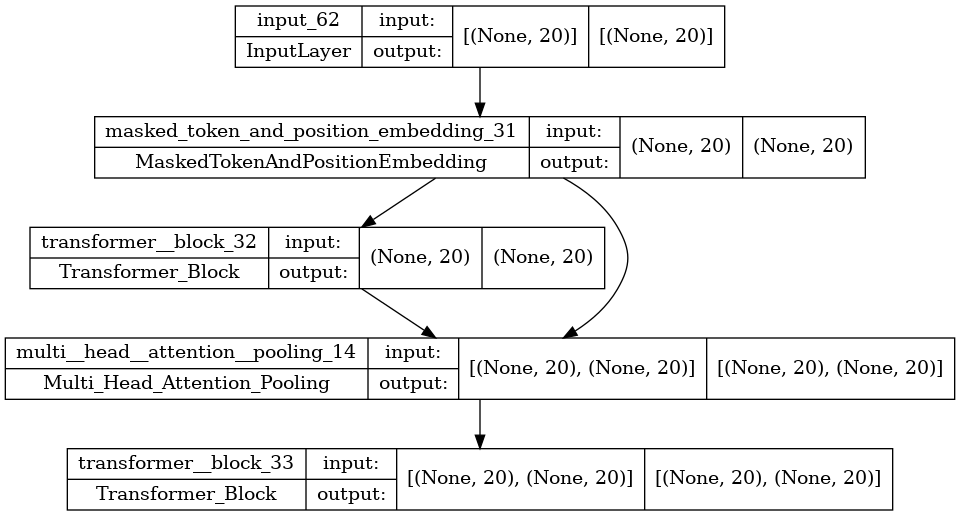

In [82]:
#Encoder
embed_dim = 512
data = input_sequences
training = True
total_words = total_words
max_sentence_length = max_sentence_length
num_heads = 8
ff_dim = 16
dropout = 0.15

encoder_stack = 1
decoder_stack = 1

input_layer = keras.layers.Input(shape=input_sequences.shape[1])

position_embedding_layer =  MaskedTokenAndPositionEmbedding(input_sequences.shape[1], total_words, embed_dim)(input_layer)

#Dropout

encoder = position_embedding_layer

for i in range(encoder_stack):
    encoder = Transformer_Block(embed_dim, num_heads, ff_dim, dropout)(encoder)

pooling_layer = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)([encoder, position_embedding_layer])

encoder = Transformer_Block(embed_dim, num_heads, ff_dim, dropout)(pooling_layer)

encoder_model = keras.Model(input_layer, encoder, name='Encoder')
keras.utils.plot_model(encoder_model,show_shapes=True,expand_nested=True)

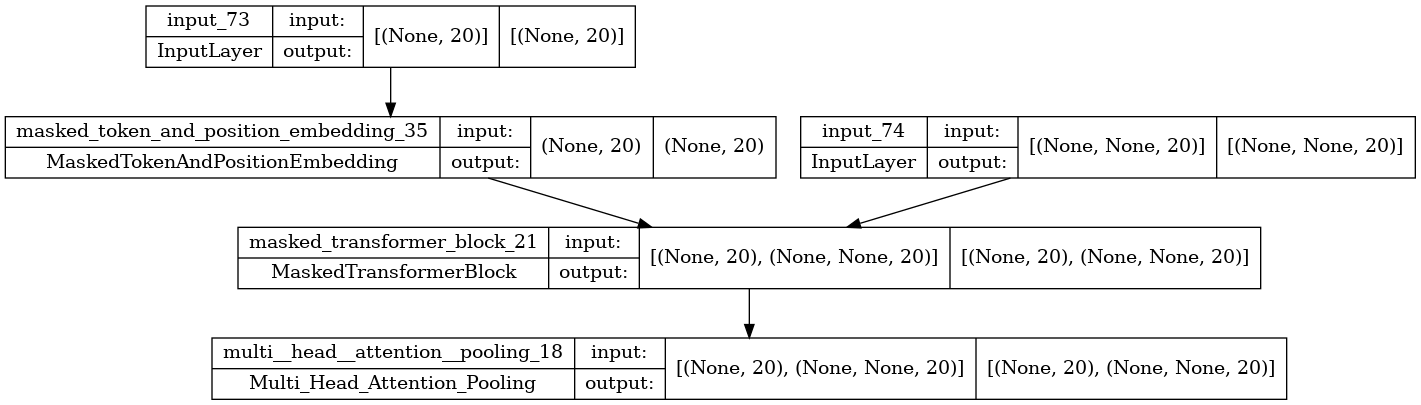

In [88]:
#Decoder 

input_layer = keras.layers.Input(shape = output_sequences.shape[1])

encoder_input_layer = keras.layers.Input(shape = encoder_model.output_shape[1])

position_embedding_layer  = MaskedTokenAndPositionEmbedding(output_sequences.shape[1], total_words, embed_dim)(input_layer)

decoder = position_embedding_layer

for i in range(decoder_stack):
    decoder = MaskedTransformerBlock(embed_dim, num_heads, ff_dim, dropout)([decoder, encoder_input_layer])
    
#linear_layer = keras.layers.Dense()(decoder)

pooling_layer = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)(decoder)

decoder_model = keras.Model([input_layer, encoder_input_layer],pooling_layer,name="Decoder")

keras.utils.plot_model(decoder_model,show_shapes=True,expand_nested=True)

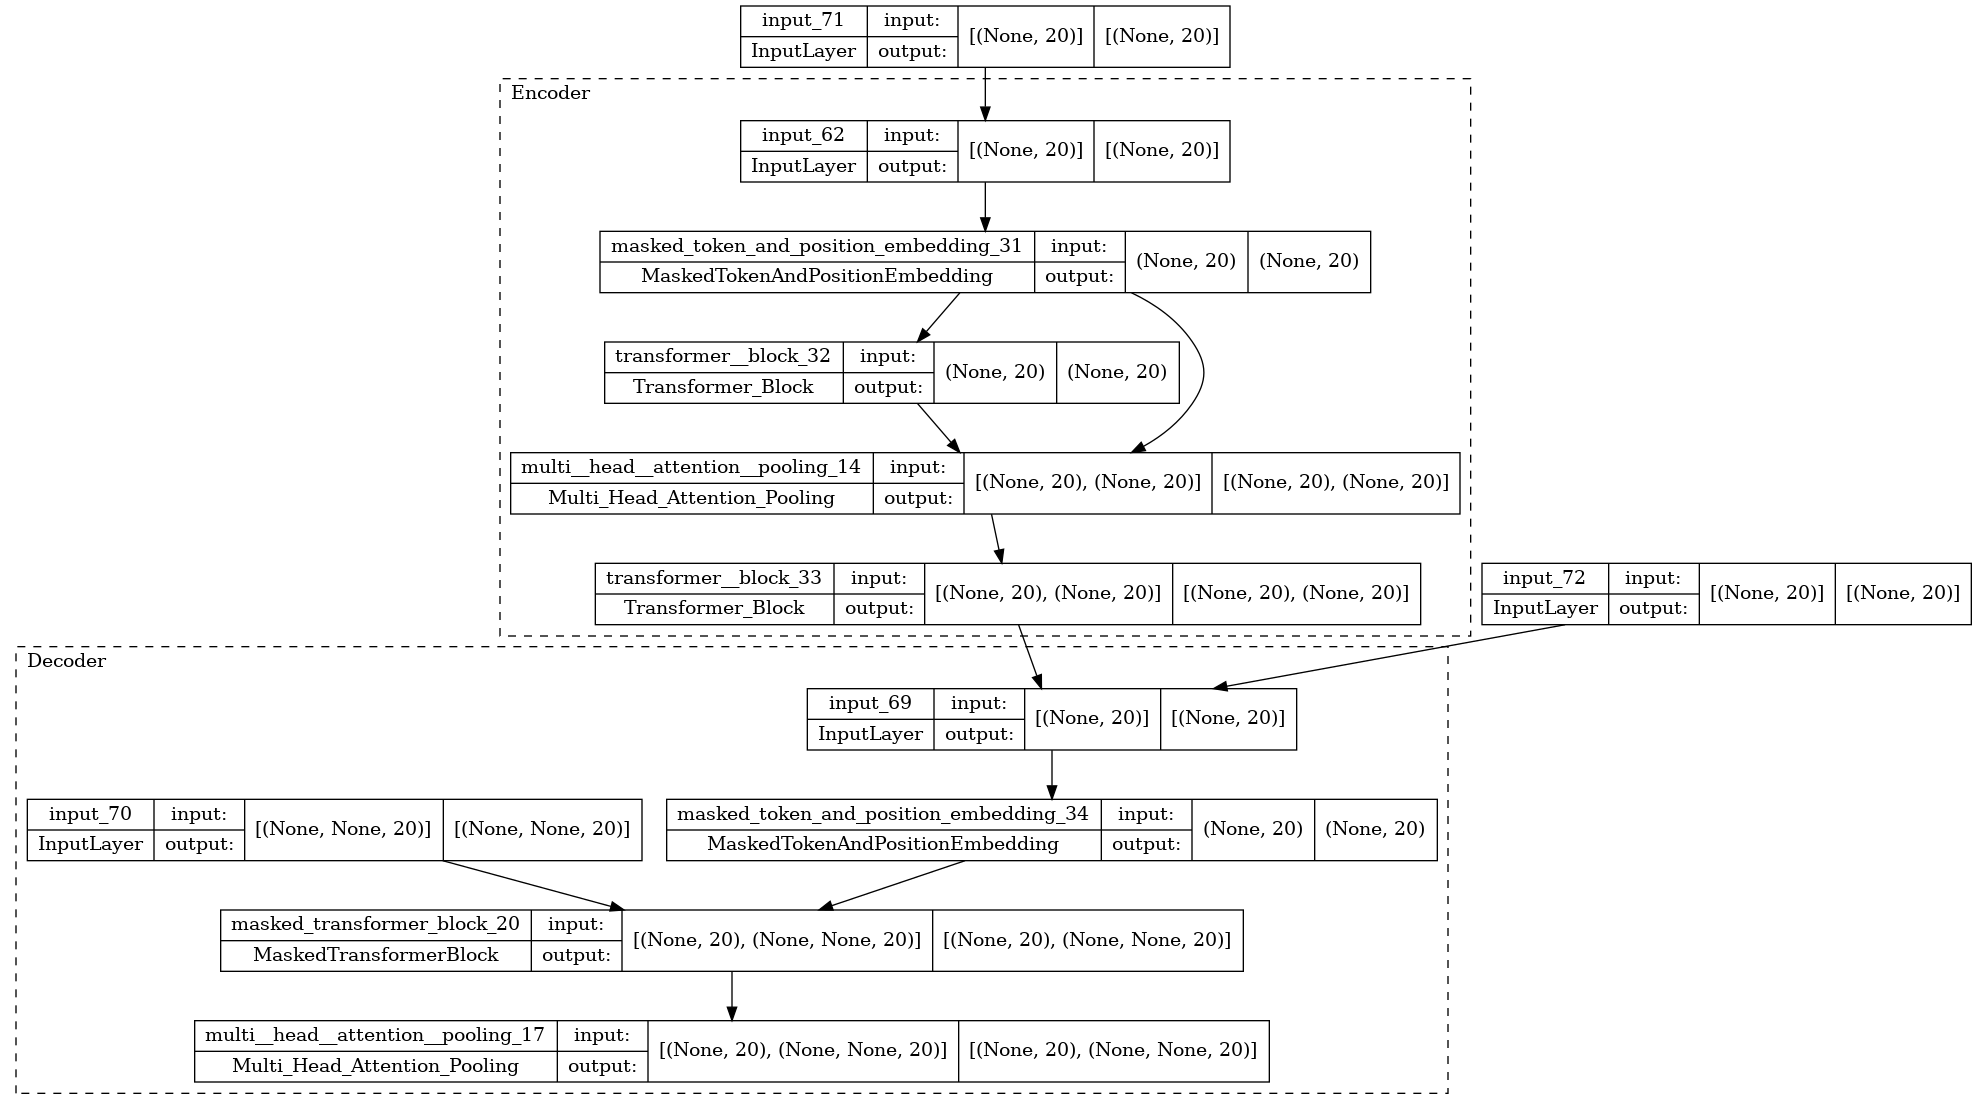

In [84]:
encoder = keras.layers.Input(encoder_model.input_shape[1:])
decoder= keras.layers.Input(decoder_model.input_shape[0][1:])


transformer = decoder_model([decoder, encoder_model(encoder)])
transformer= keras.Model([encoder, decoder],transformer)


keras.utils.plot_model(transformer,show_shapes=True,expand_nested=True)

In [45]:
# input_layer = keras.layers.Input([4, 20])
# enocder = input_layer

# for i in range(encoder_stack):
#     encoder = Encoder(data, training, total_words, embed_dim, max_sentence_length, num_heads, ff_dim, dropout)(encoder)

# pooling = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)(encoder)

# encoder = Encoder(data, training, total_words, embed_dim, max_sentence_length, num_heads, ff_dim, dropout)(pooling)
# decoder = encoder

# for i in range(decoder_stack):
#     decoder = Decoder(num_heads, embed_dim, ff_dim, dropout, data, training, total_words, max_sentence_length)(decoder)

# #For output proccesing->softmax, 
# output = keras.layers.Dense(total_words)(decoder)

# pooling = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)(decoder)

# transformer = keras.Model(input_layer, pooling)
# keras.utils.plot_model(transformer,show_shapes=True,expand_nested=True)